In [ ]:
'''
Notes

в пределах 10мб - не мусорные контакты
всю Hi-C карту предсказывать не надо. участки вдоль диагонали

удалить главную диагональ? - схлопывать


TODO: реализовать RMSE и R^2 для численной оценки качества предсказаний моделей
Разделить на 80 training, 10 dev, 10 test
Посмотреть качество предсказаний на test set'е


TODO: 
Learn only on upper triangle (2 times less output values, should be faster). 
Then, after prediction, form 2d matrix from upper triangle

TODO:
Use all chromosomes (not only one) for training and testing NN


TODO:
To reduce overfitting and increase generalization
stochastically shift input sequences by up to +/- 11 bp and reverse complement the DNA and flip the Hi-C map.
(described in Fudenberg)


Refactoring is needed!

'''

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas

pandas.set_option('display.max_columns', 500)
pandas.set_option('display.max_rows', 500)

import h5py
import random

import math
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import cooler
import cooltools as ct

from Bio import SeqIO

import pickle

import scipy
import os
import re

In [2]:
# the following directive activates inline plotting
%matplotlib inline

# allow to allocate resources for model training
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True

In [3]:
from tensorflow.keras.backend import set_session
sess = tf.Session(config=config)
set_session(sess)

In [4]:
# Constants

# Training set formation
WINDOW_SIZE = 512
STRIDE = 512 // 4

In [5]:
# UTIL FUNCTIONS

In [6]:
def plot_hic(matrix, use_log_scale = False):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    if use_log_scale:
        im = ax.matshow(np.log10(matrix), cmap='YlOrRd')
        fig.colorbar(im)
    else:
        im = ax.matshow(matrix, cmap='YlOrRd')
        fig.colorbar(im)
    

In [7]:
def one_hot_dna(sequences = {}):
    for k,v in sequences.items():
        seq_array = np.array(list(v))

        label_encoder = LabelEncoder()
        integer_encoded_seq = label_encoder.fit_transform(seq_array)

        integer_encoded_seq = integer_encoded_seq.reshape(len(integer_encoded_seq), 1)

        onehot_encoder = OneHotEncoder(sparse = False)
        result = onehot_encoder.fit_transform(integer_encoded_seq)
        
        # if Ns are present in the DNA sequence, result will have 5 columns. We delete 4th column which has Ns
        # N row in the resulting training set will have all 0s
        if result.shape[1] == 5:
            result = np.delete(result, 3, 1)
        
        sequences[k] = result

In [8]:
def select_training_squares(hic_library, chroms):
    training_set = {}

    for chrom in chroms:
        current_chrom = hic_library[chrom]
        training_set[chrom] = []
        
        for part_number in sorted(current_chrom.keys()):
            current_chrom_part = current_chrom[part_number]
            
            for i in range(0, current_chrom_part.shape[0], STRIDE):
                training_set[chrom].append((current_chrom_part[i:i + WINDOW_SIZE, i:i + WINDOW_SIZE],
                                          (i, i + WINDOW_SIZE)))
            
    return training_set

In [9]:
def form_train_x(sequences_one_hot, chroms, training_squares):
    train_x = []
    
    for chrom in chroms:
        cur_seq = sequences_one_hot[chrom]
        cur_training_squares = training_squares[chrom]

        for training_square in cur_training_squares:
            sq_begin, sq_end = training_square[1]
            train_x.append(cur_seq[(sq_begin * 1000):(sq_end * 1000), ])

            
    return np.asarray(train_x)

In [10]:
def form_train_y(training_squares, chroms):
    train_y = []
    
    for chrom in chroms:
        cur_training_squares = training_squares[chrom]
    
    for training_square in training_squares:
        # it's possible to use training_square[0].reshape(2500, 1) here if this option doesn't work
        
        # TODO: add here crop and to_upper_triu
        train_y.append(training_square[0].flatten())
        
    return np.asarray(train_y)

In [28]:
training_squares['chr2L'][4][0].shape

(512, 512)

In [12]:
# TODO: to_upper_triu, from_upper_triu
# crop from each side (?)

In [11]:
# Colab specific code
# filepath = "drive/My Drive/Colab Notebooks/S2-Wang2017-async.dm3.mapq_30.100.mcool"

filepath = "S2-Wang2017-async.dm3.mapq_30.100.mcool"

resolution = "::/resolutions/1000" # 1 KB resolution
c = cooler.Cooler(filepath + resolution)

chroms = c.chromnames
# don't use these small chromosomes
chroms.remove("chrM")
chroms.remove("chr4")

In [ ]:
# DON'T RUN: Transform all chromosome Hi-C maps and write them to file
for chrom in chroms:
    arr = c.matrix(balance=True).fetch(chrom)
    # For adaptive coarse-grain transformation purposes
    arr_raw = c.matrix(balance=False).fetch(chrom)
    
    transformed_arr = transform_hic(arr, arr_raw)
    file_name = chrom + "_transformed.npy"
    np.save(f"./transformed_hic/{file_name}", transformed_arr)

/Users/neil/anaconda3/lib/python3.7/site-packages/cooltools/lib/numutils.py:1317: RuntimeWarning: divide by zero encountered in true_divide
  val_cur = ar_cur / armask_cur
/Users/neil/anaconda3/lib/python3.7/site-packages/cooltools/lib/numutils.py:1317: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur


/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


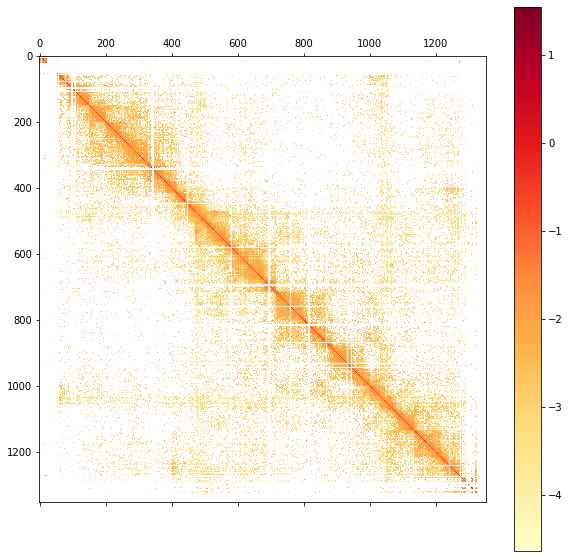

In [77]:
plot_hic(arr, use_log_scale = True)

In [12]:
# Load all transformed Hi-C
transformed_hic = {}
for chrom in chroms:
    chrom_hic_filenames = [filename for filename in os.listdir('./transformed_hic') if filename.startswith(chrom)]
    
    if len(chrom_hic_filenames) > 0:
        chrom_parts = {}
        for filename in chrom_hic_filenames:
            current_part_number = int(re.search("(transformed)(\d+)", filename).group(2))
            chrom_parts[current_part_number] = np.load(f"./transformed_hic/{filename}")['arr_0']

        transformed_hic[chrom] = chrom_parts

In [13]:
training_squares = select_training_squares(transformed_hic, chroms)

In [14]:
sequences = {}
for chrom in chroms:
    fasta_sequence = list(SeqIO.parse(open(f"./chromFa/{chrom}.fa"),'fasta'))[0]
    sequences[chrom] = str(fasta_sequence.seq)

In [15]:
# Воспринимаю маленькие и большие буквы одинаковым образом (??? Это норм ???)
for k in sequences.keys():
    sequences[k] = sequences[k].upper()

In [16]:
# Преобразую последовательности в one-hot encoding (A = 0, C = 1, G = 2, T = 3)
one_hot_dna(sequences)

/Users/neil/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/neil/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".


In [17]:
train_x = form_train_x(sequences, chroms, training_squares)

In [31]:
# TODO: stopped here

train_y = form_train_y(training_squares, chroms)

In [23]:
train_x.shape

(860, 512000, 4)

In [33]:
train_y.shape

(6050, 625)

In [29]:
# Convnet model (similar to Fudenberg NN):

model_m = Sequential()

model_m.add(layers.Conv1D(25, 50, activation='relu', input_shape=(50000, 4)))
model_m.add(layers.Conv1D(25, 50, activation='relu'))
model_m.add(layers.MaxPooling1D(5, strides = 2))

model_m.add(layers.Conv1D(50, 25, activation='relu'))
model_m.add(layers.MaxPooling1D(5, strides = 2))

model_m.add(layers.Conv1D(50, 25, activation='relu'))
model_m.add(layers.MaxPooling1D(20, strides = 4))

model_m.add(layers.Conv1D(70, 20, activation='relu'))
model_m.add(layers.MaxPooling1D(25, strides = 4))

# dilated layers
model_m.add(layers.Conv1D(100, 15, activation='relu', dilation_rate = 2))
model_m.add(layers.Conv1D(100, 15, activation='relu', dilation_rate = 2))
model_m.add(layers.MaxPooling1D(25, strides = 4))

model_m.add(layers.Flatten())
model_m.add(layers.Dense(2500, activation='linear'))

# здесь можно не использовать входы (50 штук) и схлопывать после предсказания НС
# не 2.500, а 2.450
# для тренировки и для предсказаний надо будет сначала делать трансформацию для вектора

print(model_m.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 49951, 25)         5025      
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 49902, 25)         31275     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 24949, 25)         0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 24925, 50)         31300     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 12461, 50)         0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 12437, 50)         62550     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 3105, 50)         

In [30]:
model_m.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='mse',
              metrics=['mae'])

In [ ]:
history = model_m.fit(train_x,
                      train_y,
                      batch_size=32,
                      epochs=3,
                      verbose=1)

In [31]:
model_m.load_weights('project2_model_1.h5')

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


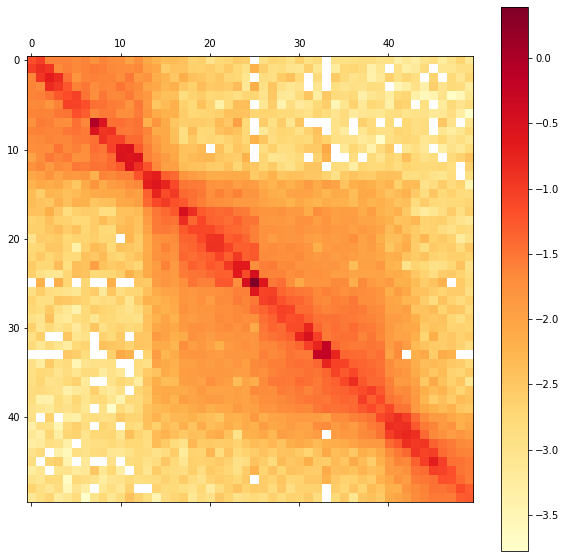

In [32]:
plot_hic(training_squares[0][0])

In [34]:
sq_begin, sq_end = training_squares[0][1]
seq_to_use = current_seq_one_hot[(sq_begin * 1000):(sq_end * 1000), ].reshape((1,50000, 4))

In [37]:
prediction = model_m.predict(seq_to_use)

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


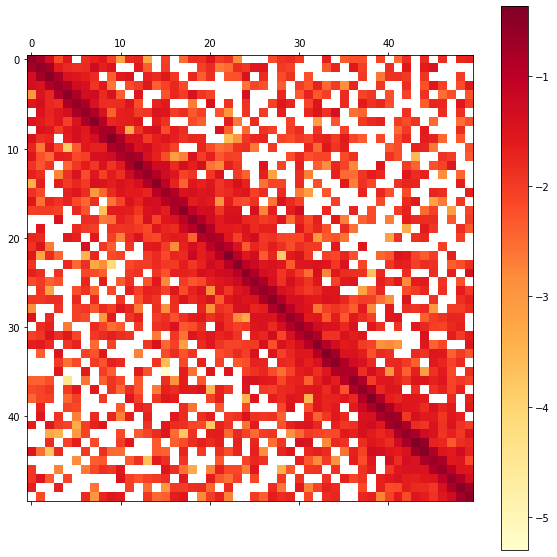

In [39]:
plot_hic(prediction.reshape((50, 50)))

In [50]:
model_m.load_weights('project2_model_2.h5')

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


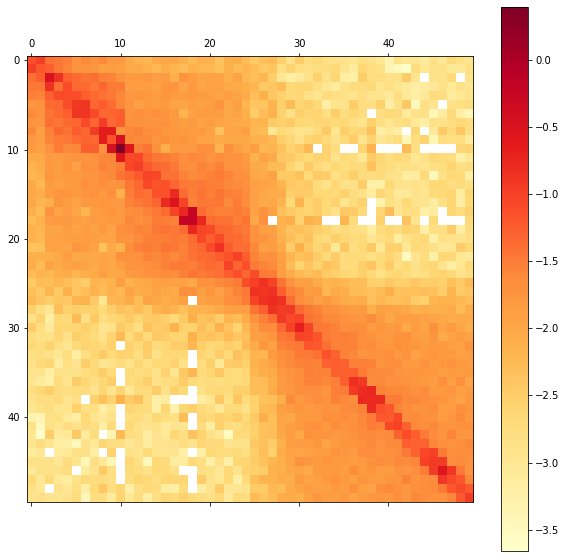

In [57]:
plot_hic(training_squares[3][0])

In [60]:
sq_begin, sq_end = training_squares[3][1]
seq_to_use = current_seq_one_hot[(sq_begin * 1000):(sq_end * 1000), ].reshape((1,50000, 4))

In [61]:
prediction = model_m.predict(seq_to_use)

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


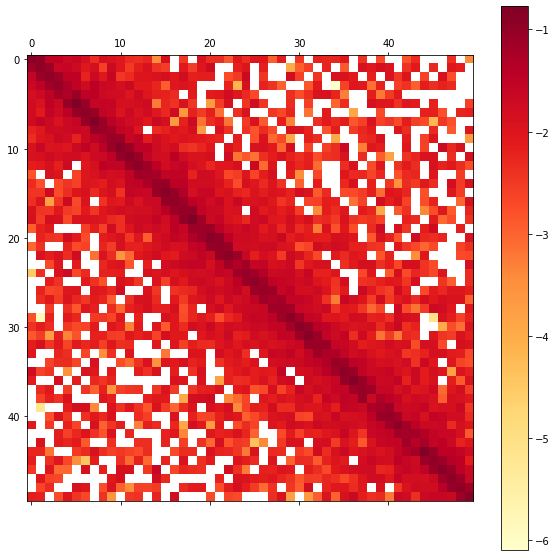

In [62]:
plot_hic(prediction.reshape((50, 50)))

In [ ]:
# Fudenberg избавляется от scaling'а
# избавиться от шкалирования. полимерное свойство хроматина нам не обязательно выучивать
# Нам надо это делать:
# observed/expected - Саша отправит
# можно применять observed/expected для всей хромосомы или для каждого квардрата 50x50
# для каждого квардрата делать observed/expected

In [ ]:
# Басет работа - 2015 (размеры слоев и параметры оттуда)
# В басет предсказывается DNA sequence -> accessibility (open versus closed chromatin) of this area 
# (in different cell types)

In [34]:
# Convnet model (similar to Basset NN):
# Basset NN is not trainable in a reasonable time with this 50x50 window size -> reduced to 25x25 window size
# Nevertheless, 3 times more tunable parameters than Fudenberg

model_m = Sequential()

model_m.add(layers.Conv1D(300, 21, activation='relu', input_shape=(25000, 4)))
model_m.add(layers.MaxPooling1D(4))

model_m.add(layers.Conv1D(300, 6, activation='relu'))
model_m.add(layers.MaxPooling1D(4))

model_m.add(layers.Conv1D(500, 4, activation='relu'))
model_m.add(layers.MaxPooling1D(4))

model_m.add(layers.Flatten())

model_m.add(layers.Dense(1000, activation='relu'))

model_m.add(layers.Dense(625, activation='linear'))

print(model_m.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 24980, 300)        25500     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6245, 300)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6240, 300)         540300    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1560, 300)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1557, 500)         600500    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 389, 500)          0         
____

In [35]:
model_m.load_weights('project2_model_Basset.h5')

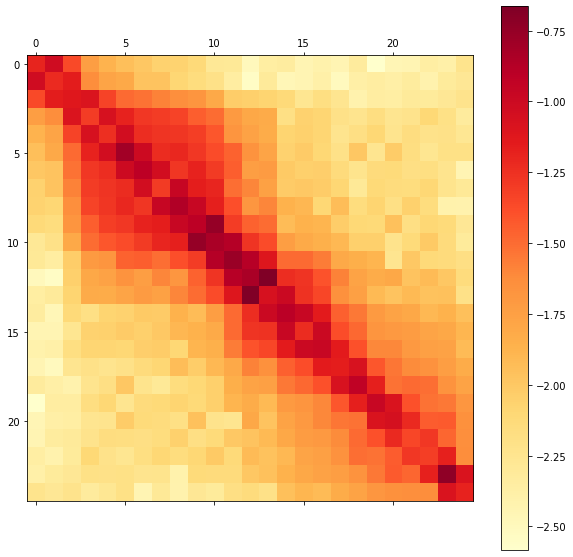

In [36]:
plot_hic(training_squares[3][0])

In [37]:
sq_begin, sq_end = training_squares[3][1]
seq_to_use = current_seq_one_hot[(sq_begin * 1000):(sq_end * 1000), ].reshape((1,25000, 4))

In [38]:
prediction = model_m.predict(seq_to_use)

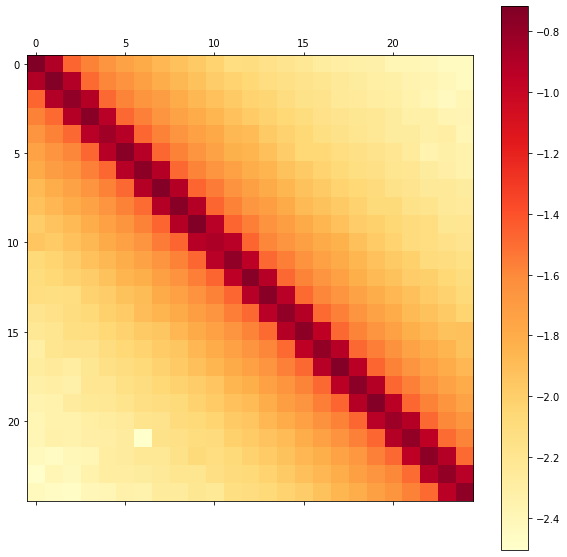

In [39]:
plot_hic(prediction.reshape((25, 25)))

In [ ]:
# Hi-C tranformations

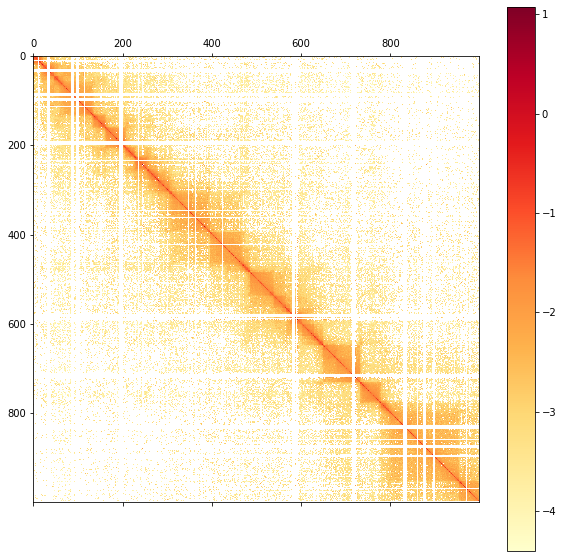

In [33]:
plot_hic(arr[0:1000, 0:1000], use_log_scale=True)

In [28]:
# Step 1: Adaptive coarse-grain
transformed_arr = ct.lib.numutils.adaptive_coarsegrain(arr[0:1000, 0:1000], arr_raw[0:1000, 0:1000])

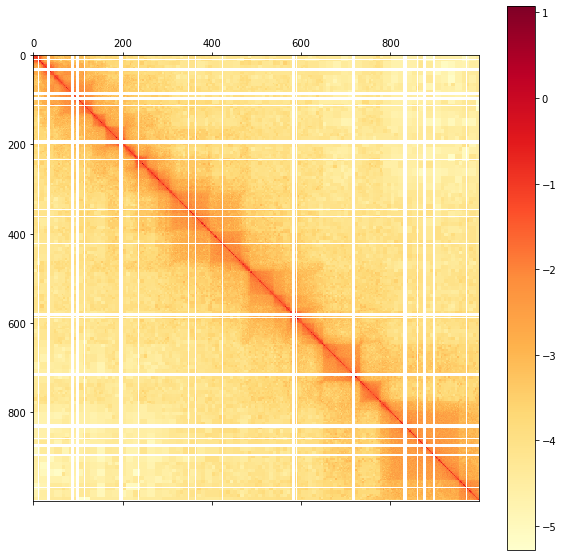

In [34]:
plot_hic(transformed_arr, use_log_scale=True)

In [35]:
# Step 2: Normalize the contact matrix for distance-dependent contact decay.
# Observed/Expected
transformed_arr, _, _, _ = ct.lib.numutils.observed_over_expected(transformed_arr, mask = ~np.isnan(transformed_arr))

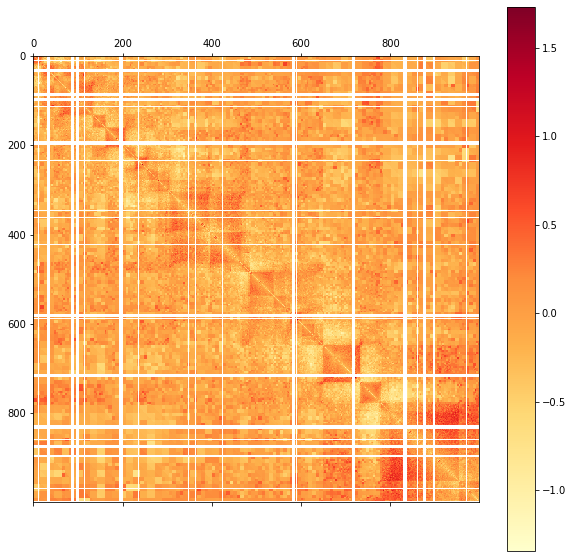

In [36]:
plot_hic(transformed_arr, use_log_scale=True)

In [37]:
# Step 3: Take natural logarithm
transformed_arr = np.log(transformed_arr)

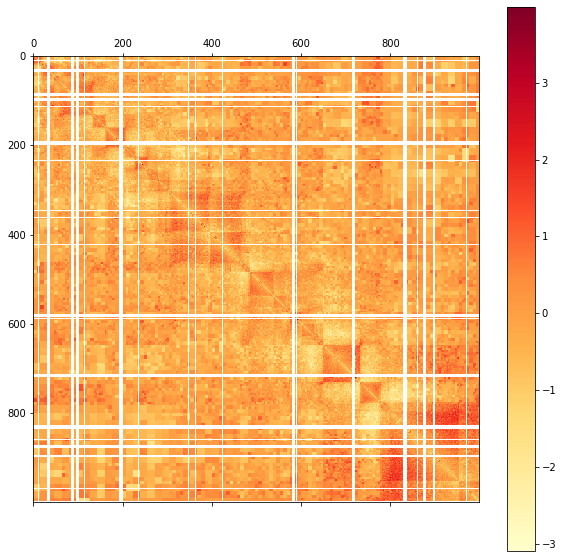

In [38]:
plot_hic(transformed_arr)

In [39]:
# Step 4: Interpolate all NaN values
transformed_arr = ct.lib.numutils.interp_nan(transformed_arr)

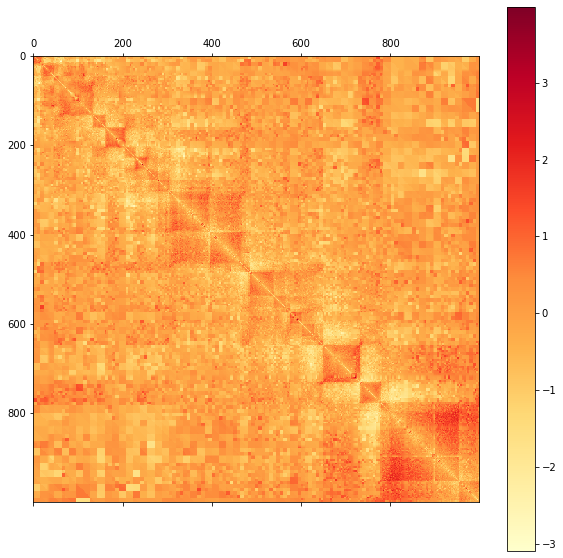

In [40]:
plot_hic(transformed_arr)

In [41]:
# Step 5: Use Gaussian filter
# To get rid of noise, emphasizing larger patterns.
transformed_arr = scipy.ndimage.gaussian_filter(transformed_arr, sigma = 1)

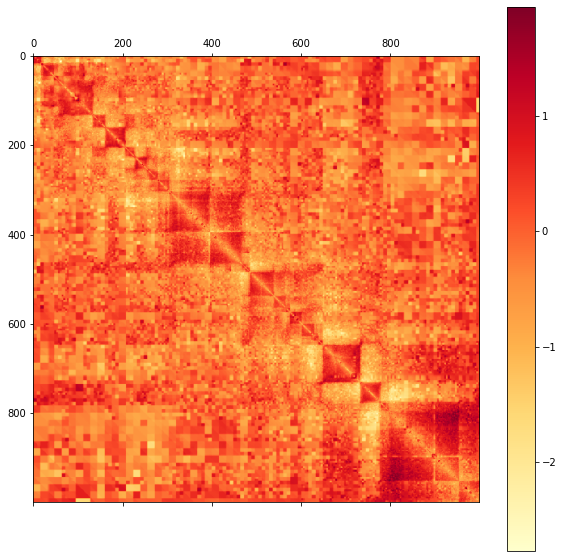

In [42]:
plot_hic(transformed_arr)

In [134]:
# combine all the transformations in one function
def transform_hic(hic_matrix, hic_matrix_raw):
    transformed_arr = ct.lib.numutils.adaptive_coarsegrain(hic_matrix, hic_matrix_raw)
    transformed_arr, _, _, _ = ct.lib.numutils.observed_over_expected(transformed_arr, mask = ~np.isnan(transformed_arr))
    transformed_arr = np.log(transformed_arr)
    transformed_arr = ct.lib.numutils.interp_nan(transformed_arr)
    transformed_arr = scipy.ndimage.gaussian_filter(transformed_arr, sigma = 1)
    
    return transformed_arr

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


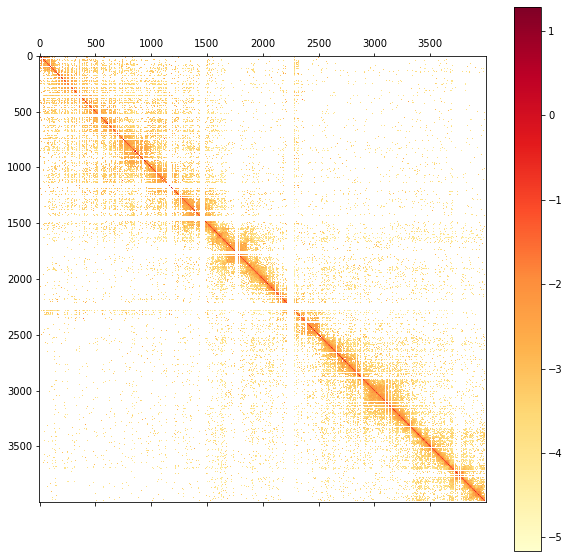

In [151]:
plot_hic(arr[0:4000, 0:4000], use_log_scale=True)

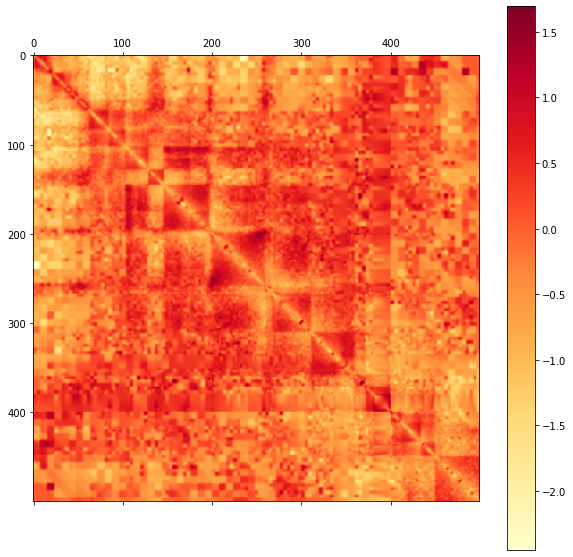

In [152]:
plot_hic(transform_hic(arr[2500:3000, 2500:3000], arr_raw[2500:3000, 2500:3000]))

In [ ]:
# TODO: RMSE and R^2. split on train and test

In [9]:
# (None, 5, 3) -> (None, 5, 5, 3)
# Explanation of the 1D -> 2D procedure

oned = tf.constant([[[1, 6, 11], 
                     [2, 7, 12], 
                     [3, 8, 13],
                     [4, 9, 14],
                     [5, 10, 15]],
                   
                    [[1, 6, 11], 
                     [2, 7, 12], 
                     [3, 8, 13],
                     [4, 9, 14],
                     [5, 10, 15]],
                   
                    [[1, 6, 11], 
                     [2, 7, 12], 
                     [3, 8, 13],
                     [4, 9, 14],
                     [5, 10, 15]]])

_, seq_len, features = oned.shape
twod1 = tf.tile(oned, [1, seq_len, 1])
twod1 = tf.reshape(twod1, [-1, seq_len, seq_len, features])
twod2 = tf.transpose(twod1, [0,2,1,3])

with tf.Session() as sess:
    print("Original tiled tensor for one 1D filter (1D filter expanded 5 times)")
    print(np.array(sess.run([twod1]))[0][0][:, :, 0])
    
    print("Transposed tiled tensor")
    print(np.array(sess.run([twod2]))[0][0][:, :, 0])


twod1 = tf.expand_dims(twod1, axis=-1)
twod2 = tf.expand_dims(twod2, axis=-1)
twod  = tf.concat([twod1, twod2], axis=-1)
twod = tf.reduce_mean(twod, axis=-1)


with tf.Session() as sess:
    print("Result of mean operation between original and transposed (mean between each pair of values in 1D filter)")
    print(np.array(sess.run([twod]))[0][0][:, :, 0])

Original tiled tensor for one 1D filter (1D filter expanded 5 times)
[[1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 4 5]]
Transposed tiled tensor
[[1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]
 [5 5 5 5 5]]
Result of mean operation between original and transposed (mean between each pair of values in 1D filter)
[[1 1 2 2 3]
 [1 2 2 3 3]
 [2 2 3 3 4]
 [2 3 3 4 4]
 [3 3 4 4 5]]


In [10]:
# Exlanation of ConcatDist2D procedure
# This layer adds one more channel which contains pairwise distances for the matrices obtained on the previous layer
# (this should enhance model performance)
# (None, 5, 5, 3) -> (None, 5, 5, 4)

# For one training example -> (1,5,5,3)
inputs = tf.random.uniform(shape=[1,5,5,3])

input_shape = tf.shape(inputs)
batch_size, seq_len = input_shape[0], input_shape[1]

## concat 2D distance ##
pos = tf.expand_dims(tf.range(0, seq_len), axis=-1)
matrix_repr1 = tf.tile(pos, [1,seq_len])
matrix_repr2 = tf.transpose(matrix_repr1, [1,0])
dist  = tf.math.abs( tf.math.subtract(matrix_repr1, matrix_repr2) )
dist = tf.dtypes.cast(dist, tf.float32)
dist = tf.expand_dims(dist, axis=-1)
dist = tf.expand_dims(dist, axis=0)
dist = tf.tile(dist, [batch_size, 1, 1, 1])

res = tf.concat([inputs, dist], axis=-1)

with tf.Session() as sess:
    print(np.array(sess.run([res]))[0, :, :, :, 3])

[[[0. 1. 2. 3. 4.]
  [1. 0. 1. 2. 3.]
  [2. 1. 0. 1. 2.]
  [3. 2. 1. 0. 1.]
  [4. 3. 2. 1. 0.]]]


In [11]:
###########################
# Custom Keras layers
###########################

In [12]:
class OneToTwo(tf.keras.layers.Layer):
    ''' Transform 1d to 2d with i,j vectors operated on.'''
    def __init__(self, operation='mean'):
        super(OneToTwo, self).__init__()

    def call(self, oned):
        _, seq_len, features = oned.shape

        twod1 = tf.tile(oned, [1, seq_len, 1])
        twod1 = tf.reshape(twod1, [-1, seq_len, seq_len, features])
        twod2 = tf.transpose(twod1, [0,2,1,3])

        twod1 = tf.expand_dims(twod1, axis=-1)
        twod2 = tf.expand_dims(twod2, axis=-1)
        twod  = tf.concat([twod1, twod2], axis=-1)
        twod = tf.reduce_mean(twod, axis=-1)

        return twod

    def get_config(self):
        config = super().get_config().copy()
        config['operation'] = self.operation
        return config

In [13]:
class ConcatDist2D(tf.keras.layers.Layer):
    ''' Concatenate the pairwise distance to 2d feature matrix.'''
    def __init__(self):
        super(ConcatDist2D, self).__init__()

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, seq_len = input_shape[0], input_shape[1]

        ## concat 2D distance ##
        pos = tf.expand_dims(tf.range(0, seq_len), axis=-1)
        matrix_repr1 = tf.tile(pos, [1, seq_len])
        matrix_repr2 = tf.transpose(matrix_repr1, [1, 0])
        dist = tf.math.abs(tf.math.subtract(matrix_repr1, matrix_repr2))
        dist = tf.dtypes.cast(dist, tf.float32)
        dist = tf.expand_dims(dist, axis=-1)
        dist = tf.expand_dims(dist, axis=0)
        dist = tf.tile(dist, [batch_size, 1, 1, 1])
        return tf.concat([inputs, dist], axis=-1)


In [14]:
class Symmetrize2D(tf.keras.layers.Layer):
    '''Take the average of a matrix and its transpose to enforce symmetry.'''

    def __init__(self):
        super(Symmetrize2D, self).__init__()

    def call(self, x):
        x_t = tf.transpose(x, [0, 2, 1, 3])
        x_sym = (x + x_t) / 2
        return x_sym

In [15]:
class UpperTri(tf.keras.layers.Layer):
    ''' Unroll matrix to its upper triangular portion.'''

    def __init__(self, diagonal_offset=2):
        super(UpperTri, self).__init__()
        self.diagonal_offset = diagonal_offset

    def call(self, inputs):
        seq_len = inputs.shape[1].value
        output_dim = inputs.shape[-1]

        triu_tup = np.triu_indices(seq_len, self.diagonal_offset)
        triu_index = list(triu_tup[0] + seq_len * triu_tup[1])
        unroll_repr = tf.reshape(inputs, [-1, seq_len ** 2, output_dim])
        return tf.gather(unroll_repr, triu_index, axis=1)

    def get_config(self):
        config = super().get_config().copy()
        config['diagonal_offset'] = self.diagonal_offset
        return config

In [16]:
###########################
# Helper functions
###########################

In [17]:
def activate(current, activation, verbose=False):
    if verbose: 
        print('activate:',activation)
    
    if activation == 'relu':
        current = tf.keras.layers.ReLU()(current)
    elif activation == 'gelu':
        current = GELU()(current)
    elif activation == 'sigmoid':
        current = tf.keras.layers.Activation('sigmoid')(current)
    elif activation == 'tanh':
        current = tf.keras.layers.Activation('tanh')(current)
    elif activation == 'exp':
        current = Exp()(current)
    elif activation == 'softplus':
        current = Softplus()(current)
    else:
        print('Unrecognized activation "%s"' % activation, file=sys.stderr)
        exit(1)

    return current

In [18]:
###########################
# Keras blocks
###########################

In [19]:
def conv_block(inputs, filters=None, kernel_size=1, activation='relu', strides=1,
    dilation_rate=1, l2_scale=0, dropout=0, conv_type='standard', residual=False,
    pool_size=1, batch_norm=False, bn_momentum=0.99, bn_gamma=None,
    kernel_initializer='he_normal'):
  
    """Construct a single convolution block.
    Args:
    inputs:        [batch_size, seq_length, features] input sequence
    filters:       Conv1D filters
    kernel_size:   Conv1D kernel_size
    activation:    relu/gelu/etc
    strides:       Conv1D strides
    dilation_rate: Conv1D dilation rate
    l2_scale:      L2 regularization weight.
    dropout:       Dropout rate probability
    conv_type:     Conv1D layer type
    residual:      Residual connection boolean
    pool_size:     Max pool width
    batch_norm:    Apply batch normalization
    bn_momentum:   BatchNorm momentum
    bn_gamma:      BatchNorm gamma (defaults according to residual)
    Returns:
    [batch_size, seq_length, features] output sequence
    """

    # flow through variable current
    current = inputs

    # choose convolution type
    if conv_type == 'separable':
        conv_layer = tf.keras.layers.SeparableConv1D
    else:
        conv_layer = tf.keras.layers.Conv1D

    if filters is None:
        filters = inputs.shape[-1]

    # activation
    current = activate(current, activation)

    # convolution
    current = conv_layer(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding='same',
        use_bias=False,
        dilation_rate=dilation_rate,
        kernel_initializer=kernel_initializer,
        kernel_regularizer=tf.keras.regularizers.l2(l2_scale))(current)

    # batch norm
    if batch_norm:
        if bn_gamma is None:
            bn_gamma = 'zeros' if residual else 'ones'
        
        current = tf.keras.layers.BatchNormalization(momentum=bn_momentum, gamma_initializer=bn_gamma, fused=True)(current)

    # dropout
    if dropout > 0:
        current = tf.keras.layers.Dropout(rate=dropout)(current)

    # residual add
    if residual:
        current = tf.keras.layers.Add()([inputs,current])

    # Pool
    if pool_size > 1:
        current = tf.keras.layers.MaxPool1D(pool_size=pool_size, padding='same')(current)

    return current

In [20]:
def conv_tower(inputs, filters_init, filters_mult=1, repeat=1, **kwargs):
    """Construct a reducing convolution block.
    Args:
    inputs:        [batch_size, seq_length, features] input sequence
    filters_init:  Initial Conv1D filters
    filters_mult:  Multiplier for Conv1D filters
    repeat:        Conv block repetitions
    Returns:
    [batch_size, seq_length, features] output sequence
    """

    # flow through variable current
    current = inputs

    # initialize filters
    rep_filters = filters_init

    for ri in range(repeat):
        # convolution
        current = conv_block(current, filters=int(np.round(rep_filters)), **kwargs)

    # update filters
    rep_filters *= filters_mult

    return current

In [21]:
def dilated_residual(inputs, filters, kernel_size=3, rate_mult=2, conv_type='standard', 
                     dropout=0, repeat=1, round=False, **kwargs):
    """Construct a residual dilated convolution block.
    Args:
    Returns:
    """

    # flow through variable current
    current = inputs

    # initialize dilation rate
    dilation_rate = 1.0

    for ri in range(repeat):
        # For skip connection purpose
        rep_input = current

        # dilate
        current = conv_block(current, filters=filters, kernel_size=kernel_size, 
                             dilation_rate=int(np.round(dilation_rate)), 
                             conv_type=conv_type, bn_gamma='ones', **kwargs)

        # return
        current = conv_block(current, filters=int(rep_input.shape[-1]), dropout=dropout, bn_gamma='zeros', **kwargs)

        # residual add
        current = tf.keras.layers.Add()([rep_input, current])

        # update dilation rate
        dilation_rate *= rate_mult
        
        if round:
            dilation_rate = np.round(dilation_rate)

    return current


In [22]:
# 2D related blocks

def concat_dist_2d(inputs, **kwargs):
    current = ConcatDist2D()(inputs)
    return current

def one_to_two(inputs, operation='mean', **kwargs):
    current = OneToTwo(operation)(inputs)
    return current

In [23]:
def conv_block_2d(inputs, filters=128, activation='relu', conv_type='standard',
    kernel_size=1, strides=1, dilation_rate=1, l2_scale=0, dropout=0, pool_size=1,
    batch_norm=False, bn_momentum=0.99, bn_gamma='ones', symmetric=False):

    """Construct a single 2D convolution block.   """

    # flow through variable current
    current = inputs

    # activation
    current = activate(current, activation)

  # choose convolution type
    if conv_type == 'separable':
        conv_layer = tf.keras.layers.SeparableConv2D
    else:
        conv_layer = tf.keras.layers.Conv2D

    # convolution
    current = conv_layer(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding='same',
        use_bias=False,
        dilation_rate=dilation_rate,
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(l2_scale))(current)

    # batch norm
    if batch_norm:
        current = tf.keras.layers.BatchNormalization(
          momentum=bn_momentum,
          gamma_initializer=bn_gamma,
          fused=True)(current)

    # dropout
    if dropout > 0:
        current = tf.keras.layers.Dropout(rate=dropout)(current)

    # pool
    if pool_size > 1:
        current = tf.keras.layers.MaxPool2D(
          pool_size=pool_size,
          padding='same')(current)

    # symmetric
    if symmetric:
        current = layers.Symmetrize2D()(current)

    return current

In [24]:
def symmetrize_2d(inputs, **kwargs):
    return Symmetrize2D()(inputs)

In [25]:
def dilated_residual_2d(inputs, filters, kernel_size=3, rate_mult=2,
                        dropout=0, repeat=1, symmetric=True, **kwargs):
    """Construct a residual dilated convolution block.
    """

    # flow through variable current
    current = inputs

    # initialize dilation rate
    dilation_rate = 1.0

    for ri in range(repeat):
        rep_input = current

        # dilate
        current = conv_block_2d(current,
                                filters=filters,
                                kernel_size=kernel_size,
                                dilation_rate=int(np.round(dilation_rate)),
                                bn_gamma='ones',
                                **kwargs)

        # return
        current = conv_block_2d(current,
                                filters=int(rep_input.shape[-1]),
                                dropout=dropout,
                                bn_gamma='zeros',
                                **kwargs)

        # residual add
        current = tf.keras.layers.Add()([rep_input, current])

        # enforce symmetry
        if symmetric:
            current = Symmetrize2D()(current)

        # update dilation rate
        dilation_rate *= rate_mult

    return current

In [26]:
def cropping_2d(inputs, cropping, **kwargs):
    current = tf.keras.layers.Cropping2D(cropping)(inputs)
    return current

In [27]:
def upper_tri(inputs, diagonal_offset=2, **kwargs):
    current = UpperTri(diagonal_offset)(inputs)
    return current

In [28]:
def dense(inputs, units, activation='softplus', kernel_initializer='he_normal',
          l2_scale=0, l1_scale=0, **kwargs):
    
    current = tf.keras.layers.Dense(
        units=units,
        activation=activation,
        use_bias=True,
        kernel_initializer=kernel_initializer,
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1_scale, l2_scale)
    )(inputs)
    
    return current

In [29]:
# Model

SEQ_LENGTH = 1048576
sequence = tf.keras.Input(shape=(SEQ_LENGTH, 4), name='sequence')

current = sequence

# TODO: Augmentation


# TRUNK:

# First 1D convolution
current = conv_block(current, filters=96, kernel_size=11, pool_size=2, batch_norm=True, bn_momentum=0.9265,
                     activation="relu")

# Multiple (11) 1D convolutions in a tower to arrive to 2048bp representation in 1D vectors
current = conv_tower(current, filters_init=96, filters_mult=1.0, kernel_size=5, pool_size=2, repeat=10, 
                     batch_norm=True, bn_momentum=0.9265, activation="relu")

# Dilated residual layers
current = dilated_residual(current, filters=48, rate_mult=1.75, repeat=8, dropout=0.4, batch_norm=True, 
                           bn_momentum=0.9265, activation="relu")

# Bottleneck 1D convolution
current = conv_block(current, filters=64, kernel_size=5, batch_norm=True, bn_momentum=0.9265,
                     activation="relu")

# final activation
current = activate(current, "relu")


# HEAD:
current = one_to_two(current)
current = concat_dist_2d(current)
current = conv_block_2d(current, filters=48, kernel_size=3, batch_norm=True, bn_momentum=0.9265,
                     activation="relu")

current = symmetrize_2d(current)
current = dilated_residual_2d(current, filters=24, kernel_size=3, rate_mult=1.75, repeat=6, dropout=0.1,
                              batch_norm=True, bn_momentum=0.9265, activation="relu")

# TODO: TRY WITHOUT CROP
current = cropping_2d(current, cropping=32)

current = upper_tri(current, diagonal_offset=2)

current = dense(current, units=1, activation="linear")

# make model
model = tf.keras.Model(inputs=sequence, outputs=current)

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, 1048576, 4)] 0                                            
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 1048576, 4)   0           sequence[0][0]                   
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1048576, 96)  4224        re_lu[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1048576, 96)  384         conv1d[0][0]                     
______________________________________________________________________________________________

In [57]:
512000 / 1000

512.0

In [ ]:
# For now, we implement NN without stochastic shift and hi-c matrix flip
# this will help performance and is TODO
# Also Fudenberg trains on 5 datasets at the same time (Multi-task training). This improves accuracy on all dataset predictions